In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [ ]:
!pip install pytorch-lightning

In [4]:
import pytorch_lightning as pl

In [30]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1,0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [6]:
####################################################
#       Create Train, Valid and Test sets
####################################################

train_data_path = "/content/drive/MyDrive/Datasets/landmark_images/train"
test_data_path = "/content/drive/MyDrive/Datasets/landmark_images/test"

train_image_paths = [] # to store image paths in list
classes = [] # to store class values

In [7]:
# 1.
# get all the paths from train_data_path and append image paths and class to the respective lists
# e.g. train path -> "/content/drive/MyDrive/Datasets/landmark_images/train/01.Mount_Rainier_National_Park/0107a8f09aeceb03.jpg"
# e.g. class -> 01.Mount_Rainier_National_Park
for data_path in glob.glob(train_data_path + '/*'):
  classes.append(data_path.split('/')[-1])
  train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print(f"train_image_path example: {train_image_paths[0]}")
print(f"class example: {classes[0]}")

train_image_path example: /content/drive/MyDrive/Datasets/landmark_images/train/06.Niagara_Falls/11bcaf47c68dbcfd.jpg
class example: 07.Stonehenge


In [8]:
# 2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

In [12]:
# 3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
  test_image_paths.append(glob.glob(data_path + '/*'))

In [18]:
len(test_image_paths[0])

25

In [19]:
test_image_paths = flatten(test_image_paths)
test_image_paths

<generator object flatten at 0x7f461cf435d0>

In [21]:
test_image_paths = list(test_image_paths)
len(test_image_paths)

1250

In [22]:
print(f"Train size: {len(train_image_paths)}\nVal size: {len(valid_image_paths)}\nTest size: {len(test_image_paths)}")

Train size: 3996
Val size: 1000
Test size: 1250


In [23]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

In [25]:
idx_to_class

{0: '07.Stonehenge',
 1: '04.Wroclaws_Dwarves',
 2: '19.Vienna_City_Hall',
 3: '02.Ljubljana_Castle',
 4: '18.Delicate_Arch',
 5: '33.Sydney_Opera_House',
 6: '27.Seattle_Japanese_Garden',
 7: '06.Niagara_Falls',
 8: '09.Golden_Gate_Bridge',
 9: '10.Edinburgh_Castle',
 10: '11.Mount_Rushmore_National_Memorial',
 11: '16.Eiffel_Tower',
 12: '26.Pont_du_Gard',
 13: '45.Temple_of_Heaven',
 14: '35.Monumento_a_la_Revolucion',
 15: '05.London_Olympic_Stadium',
 16: '31.Washington_Monument',
 17: '03.Dead_Sea',
 18: '00.Haleakala_National_Park',
 19: '34.Great_Barrier_Reef',
 20: '12.Kantanagar_Temple',
 21: '20.Matterhorn',
 22: '39.Gateway_of_India',
 23: '28.Sydney_Harbour_Bridge',
 24: '38.Forth_Bridge',
 25: '21.Taj_Mahal',
 26: '13.Yellowstone_National_Park',
 27: '48.Whitby_Abbey',
 28: '44.Trevi_Fountain',
 29: '42.Death_Valley_National_Park',
 30: '24.Soreq_Cave',
 31: '15.Central_Park',
 32: '37.Atomium',
 33: '01.Mount_Rainier_National_Park',
 34: '36.Badlands_National_Park',
 35:

In [26]:
class_to_idx

{'00.Haleakala_National_Park': 18,
 '01.Mount_Rainier_National_Park': 33,
 '02.Ljubljana_Castle': 3,
 '03.Dead_Sea': 17,
 '04.Wroclaws_Dwarves': 1,
 '05.London_Olympic_Stadium': 15,
 '06.Niagara_Falls': 7,
 '07.Stonehenge': 0,
 '08.Grand_Canyon': 37,
 '09.Golden_Gate_Bridge': 8,
 '10.Edinburgh_Castle': 9,
 '11.Mount_Rushmore_National_Memorial': 10,
 '12.Kantanagar_Temple': 20,
 '13.Yellowstone_National_Park': 26,
 '14.Terminal_Tower': 49,
 '15.Central_Park': 31,
 '16.Eiffel_Tower': 11,
 '17.Changdeokgung': 39,
 '18.Delicate_Arch': 4,
 '19.Vienna_City_Hall': 2,
 '20.Matterhorn': 21,
 '21.Taj_Mahal': 25,
 '22.Moscow_Raceway': 48,
 '23.Externsteine': 36,
 '24.Soreq_Cave': 30,
 '25.Banff_National_Park': 45,
 '26.Pont_du_Gard': 12,
 '27.Seattle_Japanese_Garden': 6,
 '28.Sydney_Harbour_Bridge': 23,
 '29.Petronas_Towers': 41,
 '30.Brooklyn_Bridge': 35,
 '31.Washington_Monument': 16,
 '32.Hanging_Temple': 44,
 '33.Sydney_Opera_House': 5,
 '34.Great_Barrier_Reef': 19,
 '35.Monumento_a_la_Revolu

In [27]:
from torch.utils.data import Dataset

#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
  def __init__(self, image_paths, transform=False):
    self.image_paths = image_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = image_filepath.split('/')[-2]
    label = class_to_idx[label]

    if self.transform is not None:
      image = self.transform(image=image)["image"]

    return image, label


In [31]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(train_image_paths, train_transforms)
val_dataset = LandmarkDataset(valid_image_paths, test_transforms)
test_dataset = LandmarkDataset(test_image_paths, test_transforms)

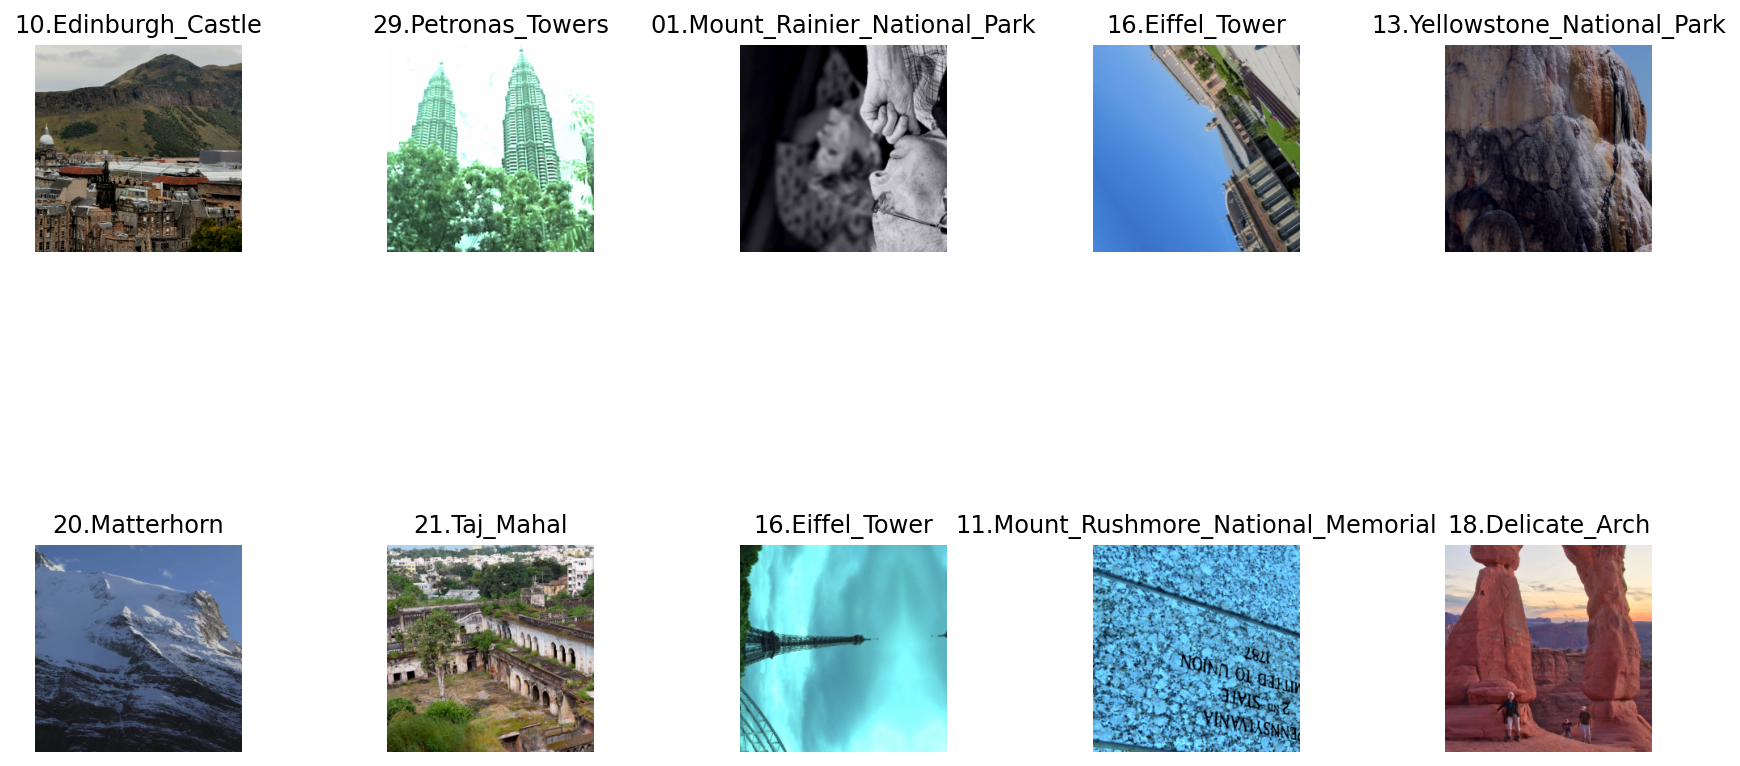

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img=False):

  dataset = copy.deepcopy(dataset)
  # we romeve the normalize and tensor conversion from our augmentation pipeline
  dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
  rows = samples // cols

  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,8))
  for i in range(samples):
    if random_img:
      idx = np.random.randint(1, len(train_image_paths))
    image, lab = dataset[idx]
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(idx_to_class[lab])

  plt.tight_layout(pad=1)
  plt.show()

visualize_augmentations(train_dataset, np.random.randint(1, len(train_image_paths)), random_img=True)

In [42]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

val_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [46]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 256, 256])

In [47]:
next(iter(train_loader))[1].shape

torch.Size([64])

In [48]:
next(iter(train_loader))[1]

tensor([24, 44, 38,  5, 21, 21, 46,  0,  9, 38, 10, 15,  8, 31, 41, 27,  5, 14,
         5, 11, 23,  3,  1,  0, 29, 24, 23, 48, 15, 17, 43,  4,  9, 43, 45, 21,
        19, 48, 41, 23,  0,  0, 31, 47, 31, 16, 35, 32, 46, 41, 46, 13,  5, 43,
        31, 20, 23, 36, 44,  9, 25, 43, 47, 34])